# Homework solution 

### Student: Megi Dervishi

In [13]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css").read()
    return HTML(styles)
css_styling()

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from imutils import paths
import random
import time
import scipy.io as sio
import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load the dataset

In [40]:
def load_data():
    #load from train -> from folder A have label 1 else have label 0
    # load from test -> same thing
    # shuffle
    print("Loading images...")
    df_train = pd.DataFrame()
    train_data, train_labels = [], []
    test_data, test_labels = [], []
    imgpath = sorted(list(paths.list_images("./data")))
    random.seed(time.time())
    random.shuffle(imgpath)
    
    for ipath in imgpath:
        #print(ipath)
        image = cv2.imread(ipath,0)
        image = image.astype('float32') / 255
        tmp1, tmp2 = ipath.split(os.path.sep)[-3] , ipath.split(os.path.sep)[-2]
        #perhaps normalize the set X
        if tmp1 == "train": 
            train_data.append(image.flatten())
            if tmp2 == "A" and tmp1 == "train": 
                train_labels.append(1)
            else:
                train_labels.append(-1)
        else: 
            test_data.append(image.flatten())
            if tmp2 == "A": 
                test_labels.append(1)
            else: 
                test_labels.append(-1)
        #print(test_data)
        #input()
                
    train_data, test_data = np.array(train_data), np.array(test_data)
    train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    #df_train['Labels'] = [list(_) for _ in keras.utils.to_categorical(train_labels, 2)]
    print("Loading dataset done.")
    return train_data, test_data, train_labels, test_labels

In [41]:
train_data, test_data, train_labels, test_labels = load_data()

Loading images...
Loading dataset done.


### Define the Dataset

The images are $28$ by $28$ pixels that range from 0 to 255 but I have normalized them to range from 0 to 1. Hence we have that $\mathcal{X} \in [0,1]^{784}$ and $\mathcal{Y} \in \{1,-1\}$

In [49]:
print("Total training images: ", train_data.shape)
print("Total testing images: ", test_data.shape)
print("Number of 'A' from the training data: {} images".format(list(train_labels).count(1)))
print("Number of 'A' from the test data: {} images ".format(list(test_labels).count(1)))
print("Shape of the images: ", train_data[0].shape)
print("Number of features for training_data or testing_data: ", test_data[0].flatten().shape)

Total training images:  (6000, 784)
Total testing images:  (750, 784)
Number of 'A' from the training data: 2000 images
Number of 'A' from the test data: 250 images 
Shape of the images:  (784,)
Number of features for training_data or testing_data:  (784,)


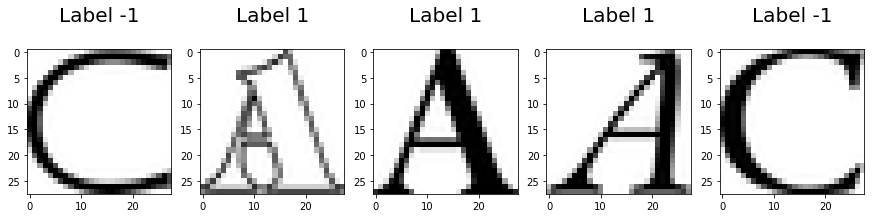

In [52]:
#examples from the dataset
plt.figure(figsize=(15,10))
for index, (image, label) in enumerate(zip(train_data[0:5], train_labels[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(image.reshape(28,28), cmap='binary')
 plt.title('Label %i\n' % label, fontsize = 20)

### Gradient Descent and Stochastic Gradient Descent

<div markdown=1 class="Def"> 
Let $\theta$ be the estimator and $X_i$ the image $i$ of the dataset $X$ and $Y_i$ the label corresponding to it. 
- Least square loss
\begin{align*}\ell_2(\theta) = \frac{1}{n}\sum_{i=1}^n (\theta^TX_i - Y_i)^2 \quad \quad \quad
\nabla_{\theta} \ell_2 &= \frac{2}{n}\sum_{i=1}^n X_i(\theta^TX_i - Y_i)\\
&= \frac{2}{n}\sum_{i=1}^n X_i\theta^TX_i - X_iY_i
\end{align*}

- Logistic square loss
\begin{align*} \ell_3(\theta) = \frac{1}{n}\sum_{i=1}^n \log(1 + e^{−Y_i\theta^T X_i}) \quad \quad
\nabla_{\theta} \ell_3 &= \frac{1}{n}\sum_{i=1}^n -X_i Y_i \frac{e^{-Y_i\theta^TX_i}}{1+e^{−Y_i\theta^T X_i}}
\end{align*}

In [267]:
def loss(ID,x,y,theta):
    if ID: 
        #square loss = 1
        return 1/len(y) * np.sum((np.dot(x,theta) - y)**2)
    else:
        #logistic loss = 0
        s = -np.dot(x, theta) * y
        return (1/len(y))*np.sum(np.log(1 + np.exp(s)))

def grad(ID, x,y,theta):
    if ID:
        # grad square loss = 1
        return 2/len(y) * np.dot(x.T, (np.dot(x, theta) - y))
    else :
        # grad logistic loss = 0
        s = -np.dot(x, theta) * y
        frac = np.exp(s)/(1+ np.exp(s))
        return -1/len(y) * np.dot(x.T, y * frac)
                
def error(data,theta, labels):
    E = np.dot(data, theta)
    acc = 0
    for x,y in zip(E, labels):
        if x > 0 and y == 1: acc += 1 
        elif x < 0 and y== -1: acc += 1
    #find the img that are hard to find
    return acc/len(labels), 1 - acc/len(labels)

In [330]:
def gradient_descent(train_x, train_y, test_x, test_y, itheta, loss_ID, eta, max_iteration):
    train_errors , test_errors = [], []
    theta = itheta
    theta_avg = itheta # Exercise 3.c
    for _ in range(max_iteration):
        train_errors.append(loss(loss_ID,train_x, train_y, theta))
        test_errors.append(loss(loss_ID, test_x, test_y, theta))
        grd = grad(loss_ID, train_x, train_y, theta)
        theta = theta - eta*grd
        theta_avg += theta
    return theta, theta_avg/max_iteration, train_errors, test_errors

def stochastic_gradient_descent(train_x, train_y, test_x, test_y, itheta, loss_ID, eta, max_iteration):
    train_errors , test_errors = [], []
    theta = itheta
    theta_avg = itheta # Exercise 3.c
    for _ in range(max_iteration):
        i = np.random.randint(0, len(train_y), size=1)
        train_errors.append(loss(loss_ID,train_x, train_y, theta))
        test_errors.append(loss(loss_ID, test_x, test_y, theta))
        grd = grad(loss_ID, train_x[i], train_y[i], theta)
        theta = theta - eta*grd
        theta_avg += theta
    return theta, theta_avg/max_iteration, train_errors, test_errors
        

In [327]:
itheta = np.ones(784)*1e-4

#GD square loss
stheta, stheta_avg, strain_errors, stest_errors = gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 1, eta = 0.001, max_iteration = 500)
#SGD square loss


In [320]:
itheta = np.ones(784)*1e-4

# GD logistic loss
ltheta, ltheta_avg, ltrain_errors, ltest_errors = gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 0, eta = 0.01, max_iteration = 500)

# SGD
#st, st_avg, strain_e, stest_e = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
#                                                               itheta, 1, eta = 0.0001, max_iteration = 60)


In [334]:
itheta = np.ones(784)*1e-4
lt, lt_avg, ltrain_e, ltest_e = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 0, eta = 0.001, max_iteration = 6000)

In [ ]:
itheta = np.ones(784)*1e-4
st, st_avg, strain_e, stest_e = stochastic_gradient_descent(train_data, train_labels, test_data, test_labels, 
                                                               itheta, 1, eta = 0.001, max_iteration = 6000)

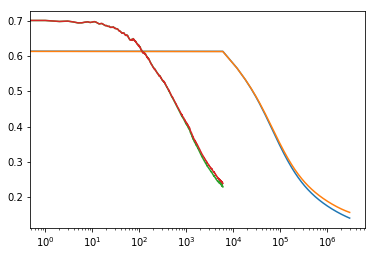

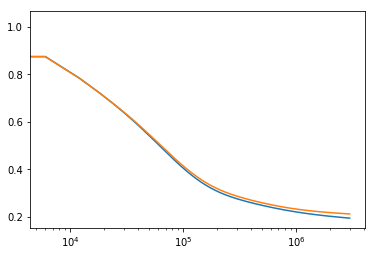

logistic = (0.9493333333333334, 0.05066666666666664)
square =  (0.952, 0.04800000000000004)
stochastic logistic =  (0.936, 0.06399999999999995)


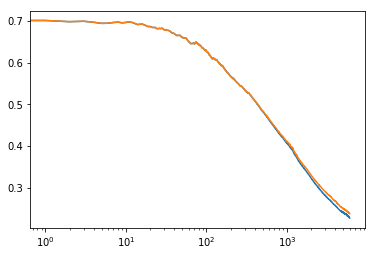

In [337]:
n =6000

plt.semilogx(n*np.arange(len(ltrain_errors)), ltrain_errors)
plt.semilogx(n*np.arange(len(ltrain_errors)), ltest_errors)
plt.show()

plt.semilogx(n*np.arange(len(strain_errors)), strain_errors)
plt.semilogx(n*np.arange(len(strain_errors)), stest_errors)
plt.show()

plt.semilogx(np.arange(len(ltrain_e)), ltrain_e)
plt.semilogx(np.arange(len(ltrain_e)), ltest_e)

print("logistic =", error(test_data, ltheta, test_labels))
print("square = ", error(test_data, stheta, test_labels))
print("stochastic logistic = ", error(test_data, lt, test_labels))
